# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Set wide fig size for plots
plt.rcParams['figure.figsize']=(12,3)

In [2]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [3]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [4]:
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [5]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)

  
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig


In [6]:
# Load data
df = pd.read_csv('Data/City_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')
df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0,255517.0,...,741586.0,745686.0,750578.0,756734.0,762321.0,768797.0,773944.0,777692.0,779960.0,781622.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0,234401.0,...,924019.0,928991.0,937936.0,953874.0,973168.0,990391.0,992337.0,992630.0,978196.0,966595.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0,109079.0,...,245783.0,248718.0,252080.0,256435.0,261101.0,265558.0,268901.0,271059.0,272400.0,272639.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0,166536.0,...,302821.0,305104.0,306404.0,308303.0,309649.0,312487.0,314663.0,315910.0,315587.0,315429.0
4,6915,4,San Antonio,city,TX,TX,"San Antonio-New Braunfels, TX",Bexar County,114794.0,114975.0,...,269323.0,274032.0,278464.0,284127.0,289739.0,294776.0,297727.0,298796.0,299124.0,298951.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22462,236350,28439,Palisades,city,TX,TX,"Amarillo, TX",Randall County,NaN,NaN,...,198490.0,198467.0,196420.0,192002.0,191634.0,189383.0,191134.0,191343.0,192384.0,192110.0
22463,40403,28439,Port Mansfield,city,TX,TX,"Raymondville, TX",Willacy County,NaN,NaN,...,229251.0,232984.0,238245.0,240154.0,242470.0,243119.0,249098.0,255572.0,261910.0,264685.0
22464,54740,28439,Tribes Hill,city,NY,NY,"Amsterdam, NY",Montgomery County,53380.0,53662.0,...,132490.0,134951.0,137470.0,137430.0,137413.0,137615.0,138908.0,140096.0,141573.0,142438.0
22465,249186,28439,Derby Center,city,VT,VT,NaN,Orleans County,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,258191.0,261607.0,264571.0,266255.0


In [7]:
# Filter just New York into a new dataframe
NY= df.loc[0:0]
NY

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0,255517.0,...,741586.0,745686.0,750578.0,756734.0,762321.0,768797.0,773944.0,777692.0,779960.0,781622.0


In [8]:
# Melt the data and drop everything but the date and home value
melted = pd.melt(NY.drop(columns=['RegionID','SizeRank','RegionName','RegionType',
                                  'StateName','State','Metro','CountyName']),
                 value_name="HomeValue",var_name="Date")
melted

,Date,HomeValue
0,2000-01-31,253690.0
1,2000-02-29,255517.0
2,2000-03-31,257207.0
3,2000-04-30,260310.0
4,2000-05-31,263204.0
...,...,...
268,2022-05-31,768797.0
269,2022-06-30,773944.0
270,2022-07-31,777692.0
271,2022-08-31,779960.0


In [9]:
# Change date to datetime datatype
melted['Date'] = pd.to_datetime(melted['Date'])
melted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       273 non-null    datetime64[ns]
 1   HomeValue  272 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.4 KB


In [10]:
# Set the date as the index
melted = melted.set_index("Date")
melted

,HomeValue
Date,
2000-01-31,253690.0
2000-02-29,255517.0
2000-03-31,257207.0
2000-04-30,260310.0
2000-05-31,263204.0
...,...
2022-05-31,768797.0
2022-06-30,773944.0
2022-07-31,777692.0


In [11]:
# Resample as monthly frequency
ts = melted.resample("M").sum()
ts

,HomeValue
Date,
2000-01-31,253690.0
2000-02-29,255517.0
2000-03-31,257207.0
2000-04-30,260310.0
2000-05-31,263204.0
...,...
2022-05-31,768797.0
2022-06-30,773944.0
2022-07-31,777692.0


In [12]:
# Filter dataset to only include values starting in 2018
ts = ts.loc['2018':]
ts.head()

,HomeValue
Date,
2018-01-31,656700.0
2018-02-28,661012.0
2018-03-31,665672.0
2018-04-30,669989.0
2018-05-31,673514.0


In [13]:
# Check for nulls
ts.isna().sum()

HomeValue    0
dtype: int64

C:\Users\klein\AppData\Local\Temp\ipykernel_15756\1851023562.py:5: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


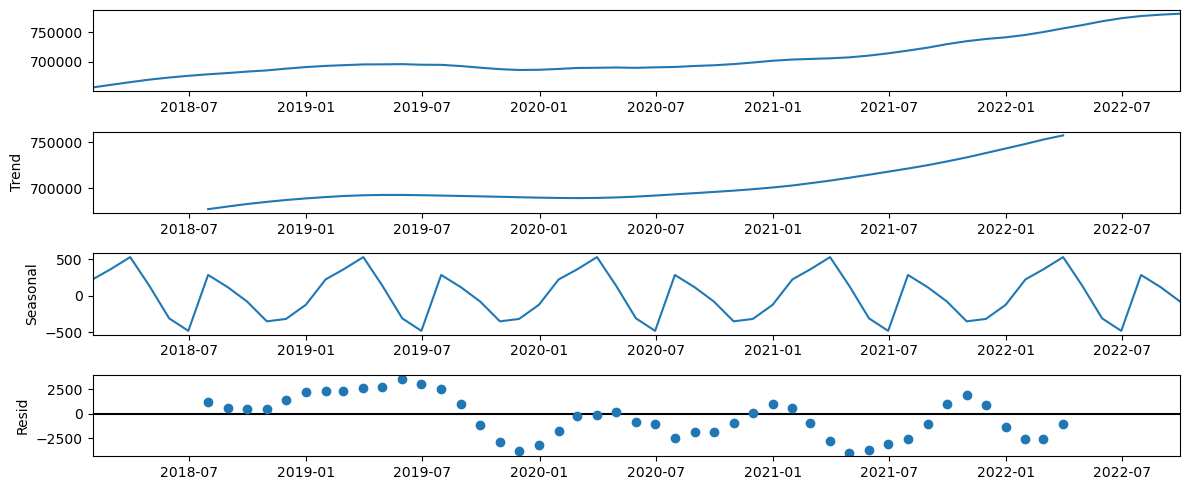

In [14]:
# Apply seasonal decomposition
decomp = tsa.seasonal_decompose(ts)
fig = decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout()

In [15]:
# Check for stationarity
get_adfuller_results(ts)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,0.407572,4,52,0.981776,0.05,False


In [16]:
# Get number for differencing
d = ndiffs(ts)
print (f'd = {d}')
# determine D
D = nsdiffs(ts, m = 12)
print (f'D = {D}')

d = 2
D = 0


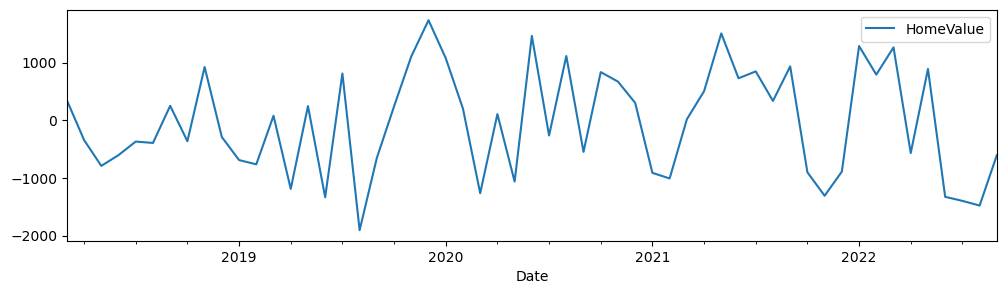

In [17]:
# Apply differencing
ts_diff = ts.diff().diff().dropna()
ts_diff.plot();

C:\Users\klein\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


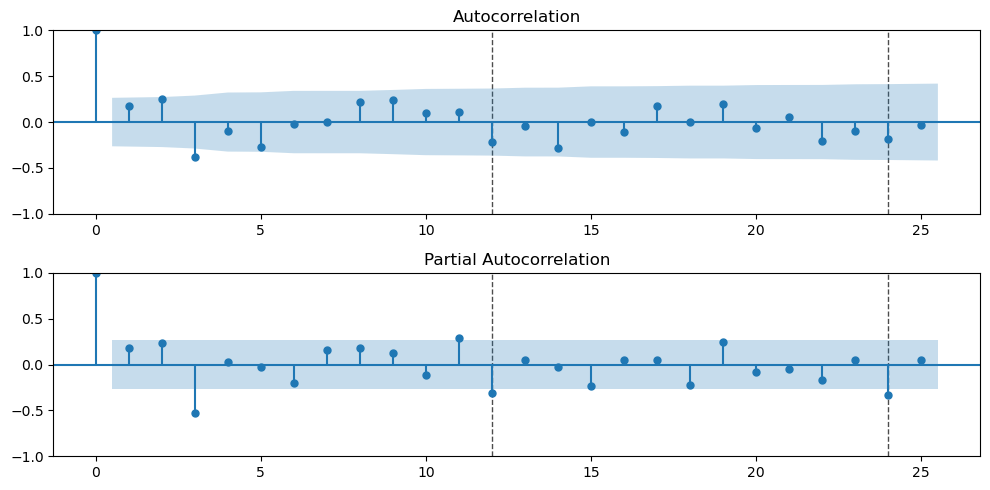

In [18]:
# now look at the acf/pacf of the stationary data
plot_acf_pacf(ts_diff, annotate_seas = True, m = 12, nlags = 25);

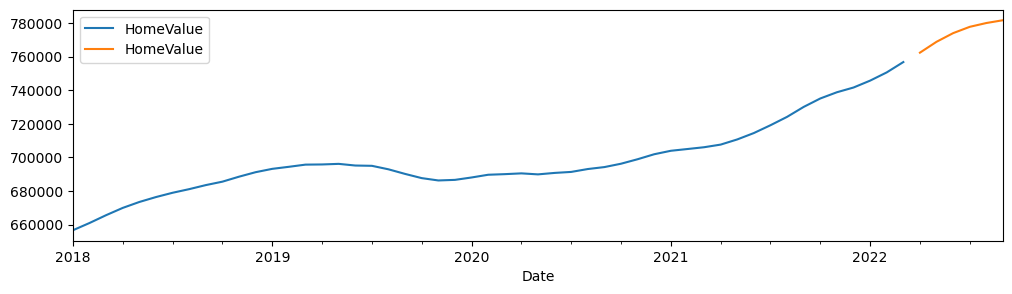

In [19]:
# Modeling to predict 6 months into the future
train, test = train_test_split(ts, test_size=6)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [20]:
# Orders for non seasonal components
p = 0  # nonseasonal AR
d = 2  # nonseasonal differencing
q = 3  # nonseasonal MA

# Orders for seasonal components
P = 3  # Seasonal AR
D = 0  # Seasonal differencing
Q = 3  # Seasonal MA
m = 12 # Seasonal period

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
sarima.summary()

C:\Users\klein\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                        HomeValue   No. Observations:                   51
Model:             ARIMA(0, 2, 3)x(3, 0, 3, 12)   Log Likelihood                -401.526
Date:                          Wed, 06 Dec 2023   AIC                            823.051
Time:                                  22:19:51   BIC                            841.969
Sample:                              01-31-2018   HQIC                           830.229
                                   - 03-31-2022                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0002      0.106     -0.002      0.999      -0.207       0.207
ma.L2          0.0032      0.066      0.049      0.961      -0.126       0.132
ma.L3          0.0034      0.051      0.067      0.946      -0.096       0.103
ar.S.L12       0.0009   9132.161   9.42e-08      1.000   -1.79e+04    1.79e+04
ar.S.L24       0.0010   1.02e+04   9.55e-08      1.000   -2.01e+04    2.01e+04
ar.S.L36       0.0019   9923.810   1.96e-07      1.000   -1.95e+04    1.95e+04
ma.S.L12       0.0009   9132.164   9.54e-08      1.000   -1.79e+04    1.79e+04
ma.S.L24   -8.551e-05   1.02e+04  -8.36e-09      1.000      -2e+04       2e+04
ma.S.L36       0.0005   9922.979      5e-08      1.000   -1.94e+04    1.94e+04
sigma2      6.939e+05    420.161   1651.476      0.000    6.93e+05    6.95e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.75   Jarque-Bera (JB):                 1.48
Prob(Q):                              0.39   Prob(JB):                         0.48
Heteroskedasticity (H):               2.31   Skew:                            -0.12
Prob(H) (two-sided):                  0.10   Kurtosis:                         2.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.04e+19. Standard errors may be unstable.
"""

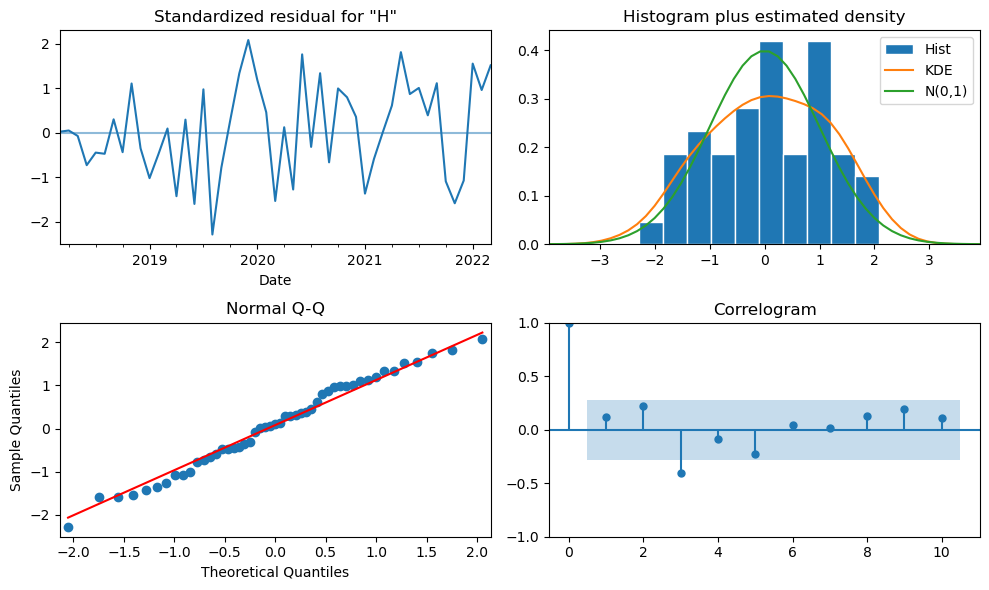

In [21]:
# Obtain diagnostic plots
fig = sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 4,271.382
- MSE = 36,920,252.049
- RMSE = 6,076.204
- R^2 = 0.182
- MAPE = 0.55%


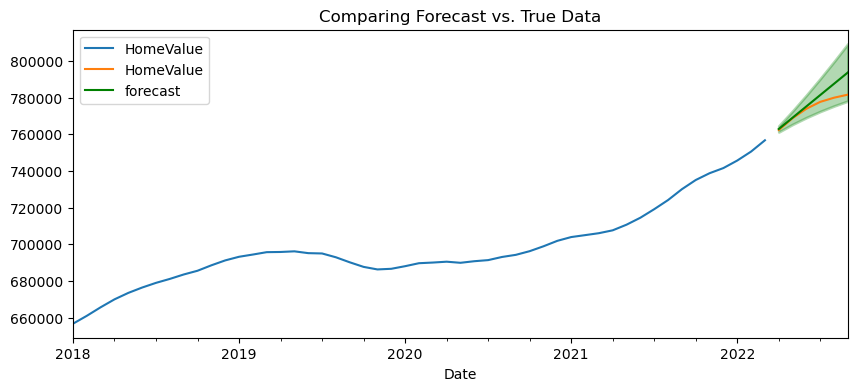

In [22]:
# Obtain forecast as a dataframe with confidence intervals
forecast_df = sarima.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

In [23]:
# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    train,
    seasonal=True,  
    m=12,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1040.350, Time=0.96 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=909.717, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=930.101, Time=0.34 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=912.587, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=940.569, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=911.717, Time=0.06 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=911.717, Time=0.04 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=913.717, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=928.324, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=910.593, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=907.207, Time=0.29 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=909.209, Time=0.65 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=1024.876, Time=0.28 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=911.393, Time=0.69 sec
 ARIMA(2,1,1)(0,0,0)[12] interc

In [24]:
# the auto_arima will store our best nonseasonal and seasonal orders seperately
print(auto_model.order)
print(auto_model.seasonal_order)

(1, 1, 1)
(0, 0, 0, 12)


In [25]:
# Obtain summary of the best model from auto_arima
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   51
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -449.603
Date:                Wed, 06 Dec 2023   AIC                            907.207
Time:                        22:19:59   BIC                            914.855
Sample:                             0   HQIC                           910.119
                                 - 51                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    593.8245   1281.385      0.463      0.643   -1917.644    3105.293
ar.L1          0.6749      0.693      0.974      0.330      -0.683       2.032
ma.L1         -0.6674      0.694     -0.962      0.336      -2.028       0.693
sigma2      3.622e+06      0.252   1.44e+07      0.000    3.62e+06    3.62e+06
===================================================================================
Ljung-Box (L1) (Q):                  37.34   Jarque-Bera (JB):                 0.01
Prob(Q):                              0.00   Prob(JB):                         0.99
Heteroskedasticity (H):               4.84   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.42e+23. Standard errors may be unstable.
"""

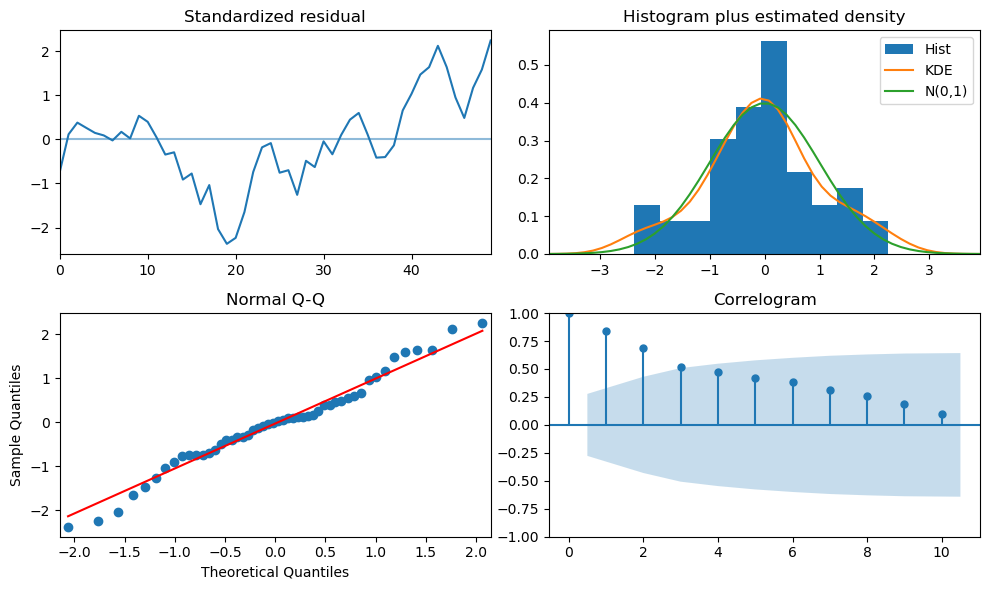

In [26]:
# Obtain diagnostic plots
fig = auto_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 9,586.366
- MSE = 101,997,632.835
- RMSE = 10,099.388
- R^2 = -1.261
- MAPE = 1.24%


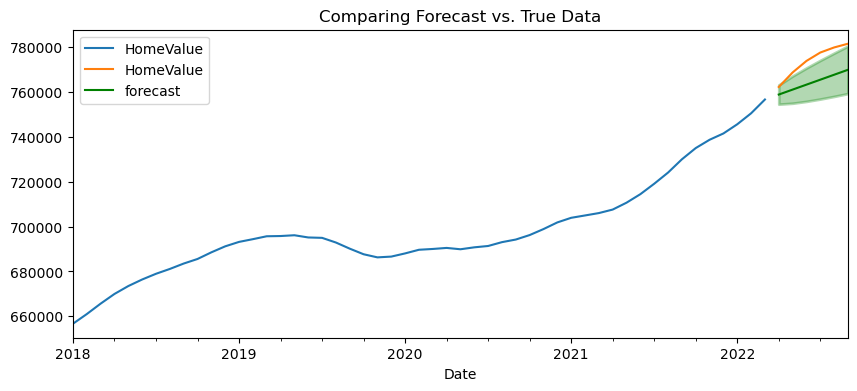

In [27]:
# Use auto_arima parameters to fit an ARIMA
auto_model = tsa.ARIMA(
    train, order=auto_model.order, seasonal_order=auto_model.seasonal_order
).fit()


# Obtain forecast as a dataframe with confidence intervals
forecast_df = auto_model.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

In [28]:
# These are the parameters of our final model
# Orders for non seasonal components
p = 0  # nonseasonal AR
d = 2  # nonseasonal differencing
q = 3  # nonseasonal MA

# Orders for seasonal components
P = 0  # Seasonal AR
D = 0  # Seasonal differencing
Q = 0  # Seasonal MA
m = 12 # Seasonal period

final_model = tsa.ARIMA(ts, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

In [29]:
# calculate the length of our test data
len(test)

6

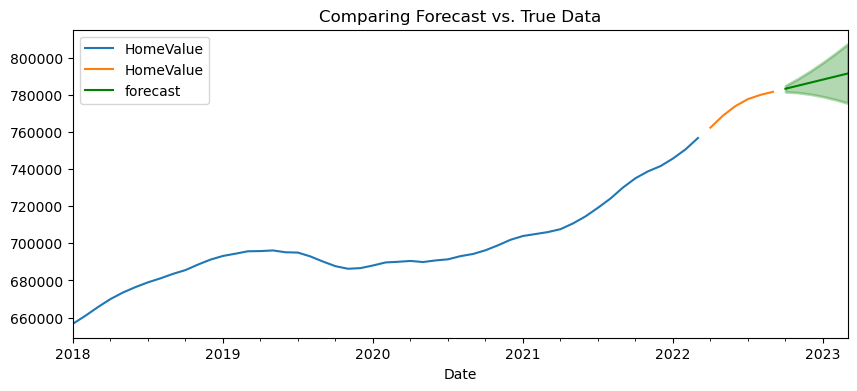

In [30]:
# Obtain future forecasts beyond test data
forecast_df  = final_model.get_forecast(len(test)).summary_frame()
plot_forecast(train,test,forecast_df);

In [31]:
# Find the starting value of our forecast
starting_value = forecast_df['mean'].iloc[0]
starting_value

783274.5141226248

In [32]:
# Find the final value of our forecast
final_value = forecast_df['mean'].iloc[-1]
final_value

791494.7072480378

In [33]:
# Calculate the change in values
change = final_value - starting_value
change

8220.193125413032

In [34]:
# Turn the change in values into a percentage of the forecast
perc_change = (change / starting_value) * 100
perc_change

1.0494651590471802

What is the predicted home value in New York City 6 months into the future (beyond the dataset)?

- The predicted home value is $791,494.71

What is the percent change in home values in New York City by the end of the 6-month forecast (beyond the dataset)?
- The percent change in home values is ~1%